# Notes, 7/9/19

## Initial attempt to compile

* ODC requires eckit 1.1.0
* ecbuild version doesn't matter
* "Fortran" missing from project statement in top-level CMakeLists.txt file
* No python API
* Got it to compile and all tests pass
    * Tests download data - first run through ctest takes 40 minutes!
    * Subsequent testing goes fast since don't have to download test data

# Notes, 7/15/19

* Reader first
* Radiosonde, AMSU-A

* Mark O. upgrade to eckit 1.1.0
    * PR's are ready

* Simon Smart is contact for ODC

# Notes, 7/15/19

* Python interface is called odyssey
    * Simon sent a tarball

* odc CMake config produces
    * libodccore
    * libodctest
    * libodctools
    
* odyssey uses libodccore

# Notes, 7/19/19

* Created odc-bundle
    * odc
    * odyssey

## python

* odyssey uses python setup.py

* use the setuptools pkg
    * packaging system built on older distutils pkg

* to save output from setup.py
~~~~~~~~
python setup.py install --record <log_file>
~~~~~~~~

* use the wheel file format for distribution
    * egg is an older format that will eventually get depricated
    * PiPY site is well uder way migrating from egg to wheel
    * to create and install a wheel file for odyessey
~~~~~~~~
# cd to the ecbuild build directory:

python setup bdist_wheel        # create the wheel file

cd dist                         # Important to do this for the following pip
                                # to work properly. Without this, the pip command
                                # (for some reason) simply points the install area
                                # to the files in the build area instead of placing
                                # copies in the install area

pip uninstall odyssey
pip install <wheel_file>
~~~~~~~~

* handy web sites
    * packaging.python.org/
    * setuptools.readthedocs.io/
    * python101.pythonlibrary.org/
    * python.packaging.readthedocs.io/en/latest/index.html


# Notes, 7/25/19

* had to write a script to do the build/install using setup.py
     * Difficult to locate wheel file
         * wheel file name changes based on platform, os, etc.
         * difficult to predit the name of the wheel file
         * difficult to use file globbing in CMake scripts
     * odyssey_setup.sh action dist_file install_dir
         * action is: build, install
         * dist_file: text file that holds the path to the wheel file
            * if action is build, then dist_file is created
            * if action is install, then dist_file is read


# Notes, 7/30/19

## Python installations

* odyssey install works with miniconda2, 3
* Does not work with container python2, 3
    * wheel file gets built okay, but pip does not install it
* pip doesn't contain the "pep425tags"
    * already upgrading pip
    * not upgrading wheel (could be this)
    * pip is found in /usr/local/bin, but python2,3 are installed in /usr/bin
* Worked with Mark and discovered that the recommended way to run pip is through the python command
~~~~~~~
python -m pip install ...
~~~~~~~

* Running pip through python gets the correct version of pip
    * Works in the containers

# Notes, 8/1/19

* Odyssey needs the following packages
    * pandas
    * cffi     (for loading libodccode)
    * pycparser
    * pytest

# Notes, 9/9/19

* AMSU-A, ATOVS example ODC file from Steve V
    * Cheyenne: /glade/work/vahl/MO_Data/OdbApi/atovs/0000/52005.odb
    * 38,333,328 rows
    * 270 columns
* To convert to netcdf
    * use codyssey to decode odb file into a pandas frame
    * convert pandas frame to xarray
    * use xarray to_netcdf method to create netcdf file
        * Encoding
        * Build a dictionary indexed by variable name to specify netcdf encodings
           * Can set things like \_FillValue, compression, etc.
           * Example:
               * xarray uses NaN as netcdf fill value
               * Remove nan as fill value
               * Enable compression
~~~~~~~~
{ 'variable1' : {
  '_FillValue' : None,
  'zlib' : True,
  'complev' : 6 } }
~~~~~~~~

* Python packages required for this:
    * pandas
    * pytest
    * xarray

* Performance testing
    * Start with large files (AMSU-A, ATOVS)
    * ODB and netcdf files with identical contents
    * Just read in the contents and time that piece
        * Any conversion/reformatting to get into IODA memory should be similar for radiance data
        * ODB has giant vector, but channels are regularly spaced so should be able to view as 2D array
            * Ie, the linear memory storage matches what is needed for 2D array

# Notes, 10/9/19

* The Fortran interface is the most developed one since the first client of ODC was using Fortran
* The C++ interface is just a place holder at this point and will be going away
* The C interface is nearly a one-for-one mapping with the Fortran interface
    * Fortran test code can be used to guide how to use the C interface

| Fortran routine | C routine |
|:----------------|:----------|
|odc_api_initialise|odc_initialise_api|
|||
|reader%open_path|odc_open_path|
|reader%close|odc_close|
|||
|frame%initialise|odc_new_frame|
|frame%next|odc_next_frame|
|frame%free|odc_free_frame|
|||
|decoder%initilise|odc_new_decoder|
|decoder%defaults_from_frame|odc_decoder_defaults_from_frame|
|decoder%decode|odc_decode|
|decoder%data|odc_decoder_data_array|
|decoder%free|odc_free_decoder|

* Use the Fortran code as a guide for development using the C inteface
    * Nearly one-to-one mapping of API routines
    * Use odc_ls.F90 as a guide instead of the "odc ls" command

## Frame layout

* The data array is an array of void\* in 8-byte chunks
* Each element (column) in the frame is 8 bytes of void\*
    * This is 8 characters for a string
    * To store longer strings, multiple columns are allocated
        * Eg, 20 byte timestamp would need 3 columns (3 * 8 = 24 bytes)
    * Column attributes
        * name
        * type (ODC_INTEGER, ODC_REAL, ODC_DOUBLE, ODC_STRING, ODC_BITFIELD)
        * element_size (number of bytes)
        * element_size_doubles (number of columns)
        * bitfield_count (number of bits that are of signficance in the column)
    * In order to parse the frame, you must keep track of the starting column and size (number of columns) for each item
* By default frames contain a maximum of 10000 rows
* Set ODC_INTEGERS_AS_LONGS, which will store the bit pattern for a long in the frame data array column
    * This will avoid the need to do the static_cast step


# Notes from Yannick's visit to ECMWF, 10/24/19

* Each variable in a separate column
    * Concerned about inefficiency
        * With radiances, many channels and many columns would be generated
        * Many columns may be detrimental to speed of access to the file
    * ECMWF is interested in what we find in regard to performances with this scheme
* Radiance
    * One pixel (column) is one record
* Frames
    * Keep records intact within a frame
    * Not keen on this, but Peter Lean is advocating this
    * If records are intact within a frame, then threads could be used
* MPI
    * N tasks -> split files so one file feeds 10, 20 tasks
    * One task reads the file and distributes to the others in their group
    * Random distribution (like what we do with round robin)
    * Same MPI tasks work on the DA flow downstream
    * Communicator groups
        * 10, 20 tasks per group (as noted above)
        * Each comm group gets a file
* Compare both of these schemes:
    * All obs values in one column
    * Each variable in a separate column
* Eventually need knob with number of MPI tasks (N) in one group
    * Start with N = 1 (each task gets one file)
    * N = 20 (one file per 20 tasks)

# Performance testing, 1/10/20

* S4
    * build, test and install fv3-bundle for jedi rapids testing
        * Install dir: /data/users/sherbener/jedi-install
        * Include GWS, ROPP, and GEOS AERO
        * Working - all tests pass
    * build, test and install ioda-converters feature/nc2odb branch
        * Add script to walk through directory and convert all netcdf files
        * Working - all tests pass
        

# Performance testing, 1/15/20

* Create test files by concatenating netcdf files, or by sampling from netcdf files, and then converting those to odb

```
# To create a file with twice as many locations
# ncrcat concatenates netcdf files
# ncrcat can only concatenate along dimensions that are unlimited in size
#
ncks --mk_rec_dim nlocs infile outfile   # change nlocs to unlimited
ncrcat outfile outfile doublefile

# To sample n loctaions from a given file use -d option of ncks
# parameters to -d option correspond to netcdf hyperslab
#    -d dimension,start,count,stride
#    if stride is omitted, then it is set to 1
#
ncks -d nlocs,0,999 infile outfile   # outfile will contain the first
                                     # 1000 entries indexed by nlocs
```

* Running on Cheyenne
    * Set NETCDF_PATH for ecbuild with the jedi/intel17-impi module loaded
    * ctest failures
        * nccmp cannot find netcdf library (26 bump test failures)
        * light differences in output (3 UFO failures and 1 fv3 failure)

```
bufrlib_DIR="" ecbuild -DNETCDF_PATH=/glade/u/apps/ch/opt/netcdf-mpi/4.6.3/impi/2017.1.132/intel/17.0.1 -DCMAKE_INSTALL_PREFIX=/glade/work/stephenh/jedi-install --build=RelWithDebInfo ..

```

* Running on S4
    * Use the /scratch disk instead of /data to avoid timing the auto compression that occurs on /data
    * Dan's example: SteveHighRes (on AWS)

```
# To get Dan's example 3DVar 
mkdir SteveHighRes
aws s3 sync s3://fv3-jedi/SteveHighRes SteveHighRes

# To copy to S4
rsync -av SteveHighRes sherbener@s4-gateway.ssec.wisc.edu:/scratch/users/sherbener/projects

# login to S4
# remember to go to the s4-submit node
cd /scratch/users/sherbener/projects/SteveHighRes
mkdir Data/Analysis
mkdir Data/Hofx
```

* Dan's exmaple
    * 12 X 12 X 6 faces -> 864 MPI tasks
    * Only assimilating: aircraft, Rass, Radiosonde, Satwind
    * Data/Hofx gets 4 sets (864 files) of files for the above obs
    * Layout is c192, Dan also provided a c768 (high-res) layout
        * Mark M is interested in the c768 run to test container performance

* 3DVar with AMSU-A crashes
    * Tried upping memory from 5G/core to 8G/core, but this didn't help
    * Yannick suspects that this might be a BUMP issue
    * Obs get read in and it appears to get through H(x) okay
        * Jo/n stats start appearing

# Performance testing, 1/24/20

* Run arm-forge MAP on the 256K locations test on Cheyenne
    * Re-run ecbuild with --build=RelWithDebInfo
    * Screen shot of function ranking from the MAP profiling
    
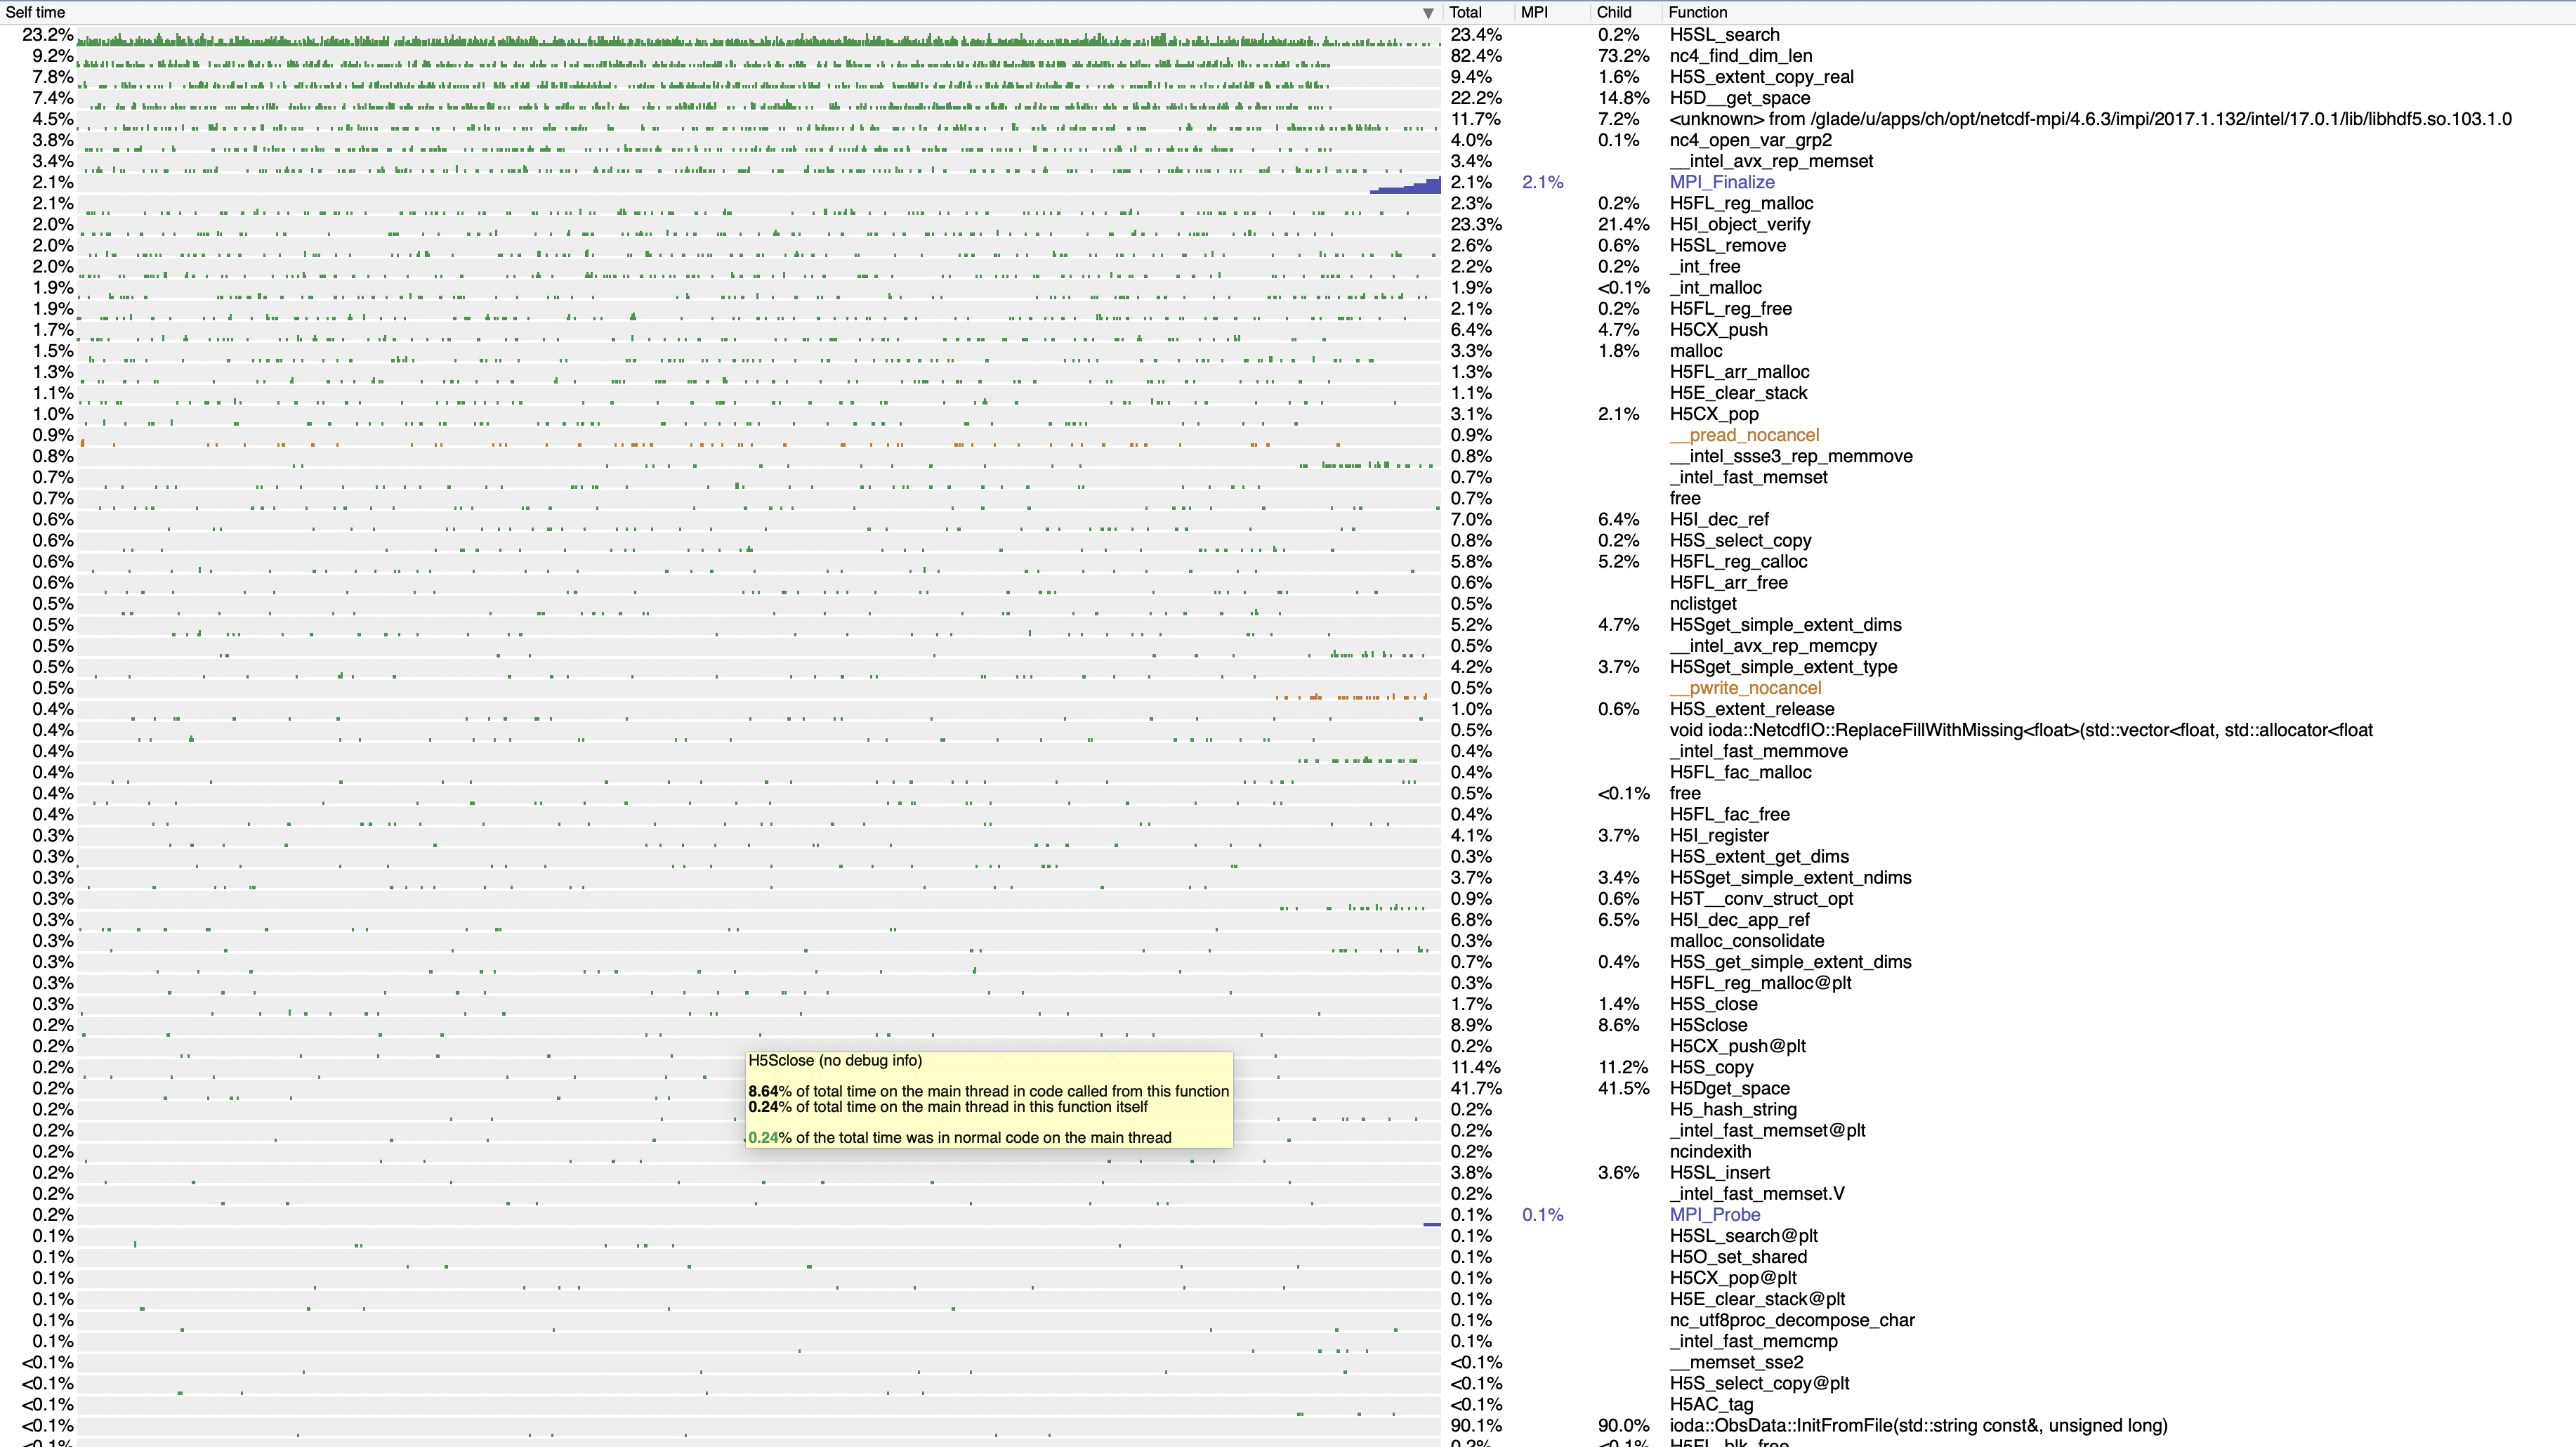